In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter, generic_filter
import os

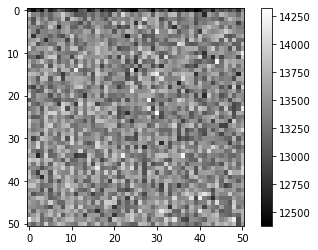

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Load the FITS file
hdul = fits.open('window_mode/win_1399_317_50.fits')
data = hdul[0].data

plt.imshow(data, cmap='gray')
plt.colorbar()
# Save the plot as a PNG file
plt.savefig('win_1399_317_50.png')

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits

# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define threshold based on local statistics
    threshold = local_mean + threshold_factor * local_std

    # Identify bad pixels based on thresholding
    bad_pixel_mask = image_data > threshold

    # Get coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Function to calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Function to calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

# Function to process multiple FITS files and analyze channels
def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    # Read the first FITS file for spatial noise calculation
    hdul = fits.open(fits_filenames[0])
    image_data = hdul[0].data  # Access the primary HDU data
    hdul.close()

    # Count and locate bad pixels
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)

    # Calculate spatial noise using window method
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)

    # Initialize an array to accumulate temporal noise data
    image_stack = []

    for fits_filename in fits_filenames:
        # Read each FITS file individually
        hdul = fits.open(fits_filename)
        image_data = hdul[0].data  # Access the primary HDU data
        hdul.close()

        # Append the image data to the stack
        image_stack.append(image_data)

    # Convert the list to a numpy array for temporal noise calculation
    image_stack = np.array(image_stack)

    # Calculate temporal noise
    temporal_noise = calculate_temporal_noise(image_stack)

    # Analyze each channel
    channels = 32
    columns_per_channel = 64
    best_channel = None
    best_channel_score = float('inf')

    for channel in range(channels):
        start_col = channel * columns_per_channel
        end_col = start_col + columns_per_channel

        channel_bad_pixels = np.sum(bad_pixel_mask[:, start_col:end_col])
        channel_spatial_noise = np.mean(spatial_noise[:, start_col:end_col])
        channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])

        # Combine metrics to score the channel
        channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise

        if channel_score < best_channel_score:
            best_channel_score = channel_score
            best_channel = channel

    print(f"Best channel: {best_channel}")
    print(f"Score: {best_channel_score}")

    return best_channel, best_channel_score

# Example usage with the provided filenames pattern
fits_filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{str(i).zfill(4)}_M0001_N0001.fits' for i in range(1, 11)]
threshold_factor = 5
neighborhood_size = 3
window_size = 10  # Adjust this size as needed

best_channel, best_channel_score = process_images(fits_filenames, threshold_factor, neighborhood_size, window_size)



Best channel: 20
Score: 891.8737335060957


## bad pixel spread

Testing with threshold factor: 50
Number of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: 762


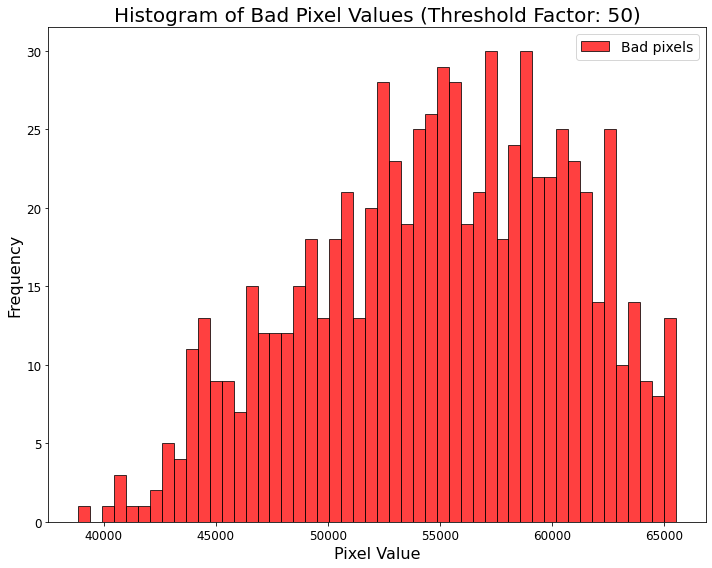

In [3]:
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define threshold based on local statistics
    threshold = local_mean + threshold_factor * local_std

    # Identify bad pixels based on thresholding
    bad_pixel_mask = image_data > threshold

    # Get coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    # Read FITS file
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()

    # Count and locate bad pixels
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, 
                                                                                   threshold_factor, neighborhood_size)

    print(f"Number of bad pixels in {fits_filename}:", num_bad_pixels)
    
    # Extract bad pixel values
    bad_pixel_values = image_data[bad_pixel_mask]
    
    return bad_pixel_values

def plot_histogram(bad_pixel_values, title="Histogram of Bad Pixel Values"):
    plt.figure(figsize=(10, 8))
    plt.hist(bad_pixel_values, bins=50, alpha=0.75, color='red', edgecolor='black', label= 'Bad pixels')
    plt.title(title, fontsize=20)
    plt.xlabel('Pixel Value', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('bad_pixel_dist.png', dpi=300)
    plt.show()

# Parameters
threshold_factors = [50]
neighborhood_size = 80  # Adjust this size
window_size = 10  # Adjust this size

# Process each image in the folder
fits_filenames = ["ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits"]

for factor in threshold_factors:
    print(f"Testing with threshold factor: {factor}")
    for fits_filename in fits_filenames:
        bad_pixel_values = process_image(fits_filename, factor, neighborhood_size, window_size)
        plot_histogram(bad_pixel_values, title=f"Histogram of Bad Pixel Values (Threshold Factor: {factor})")


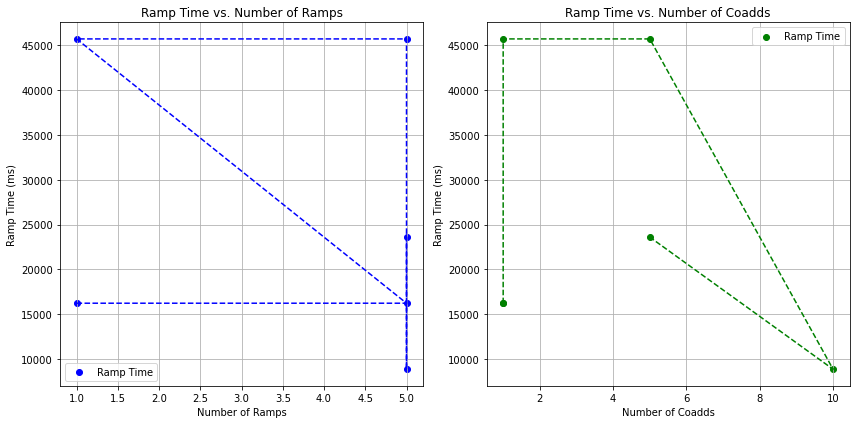

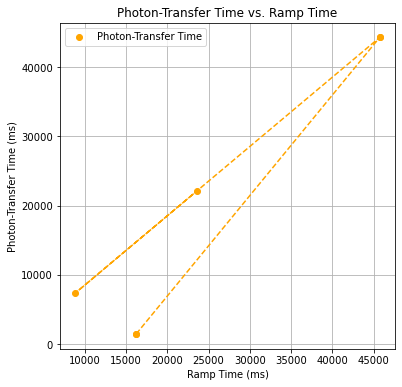

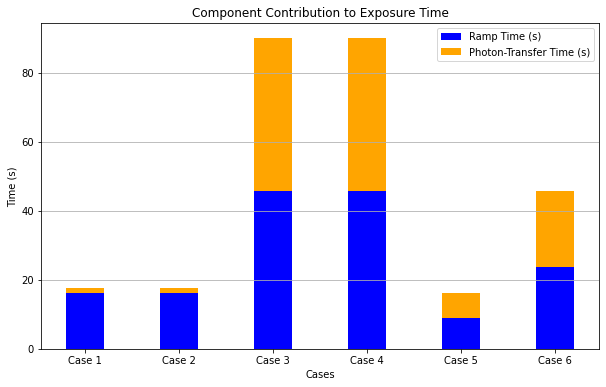

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the table
cases = [1, 2, 3, 4, 5, 6]
ramps = [1, 5, 1, 5, 5, 5]
coadds = [1, 1, 1, 5, 10, 5]
frame_time = 1475.28  # in ms (constant across all cases)
ramp_time = [2950.56,16228.08, 16228.08, 45733.68, 45733.68, 8851.68, 23604.48]  # in ms
photon_time = [1475.28, 1475.28, 44258.40, 44258.40, 7376.40, 22129.20]  # in ms
exp_time = [16.23, 81.14, 45.73, 1143.34, 442.58, 590.12]  # in seconds

# Plot 1: Ramp Time vs. Number of Ramps and Coadds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(ramps, ramp_time, color="blue", label="Ramp Time")
plt.plot(ramps, ramp_time, linestyle="--", color="blue")
plt.xlabel("Number of Ramps")
plt.ylabel("Ramp Time (ms)")
plt.title("Ramp Time vs. Number of Ramps")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(coadds, ramp_time, color="green", label="Ramp Time")
plt.plot(coadds, ramp_time, linestyle="--", color="green")
plt.xlabel("Number of Coadds")
plt.ylabel("Ramp Time (ms)")
plt.title("Ramp Time vs. Number of Coadds")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plot 2: Photon-Transfer Time vs. Ramp Time
plt.figure(figsize=(6, 6))
plt.scatter(ramp_time, photon_time, color="orange", label="Photon-Transfer Time")
plt.plot(ramp_time, photon_time, linestyle="--", color="orange")
plt.xlabel("Ramp Time (ms)")
plt.ylabel("Photon-Transfer Time (ms)")
plt.title("Photon-Transfer Time vs. Ramp Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: Component Contribution to Exposure Time
plt.figure(figsize=(10, 6))
width = 0.4
indices = np.arange(len(cases))
plt.bar(indices, np.array(ramp_time) / 1000, width=width, label="Ramp Time (s)", color="blue")
plt.bar(indices, np.array(photon_time) / 1000, width=width, label="Photon-Transfer Time (s)", bottom=np.array(ramp_time) / 1000, color="orange")
plt.xticks(indices, [f"Case {c}" for c in cases])
plt.xlabel("Cases")
plt.ylabel("Time (s)")
plt.title("Component Contribution to Exposure Time")
plt.legend()
plt.grid(axis="y")
plt.show()


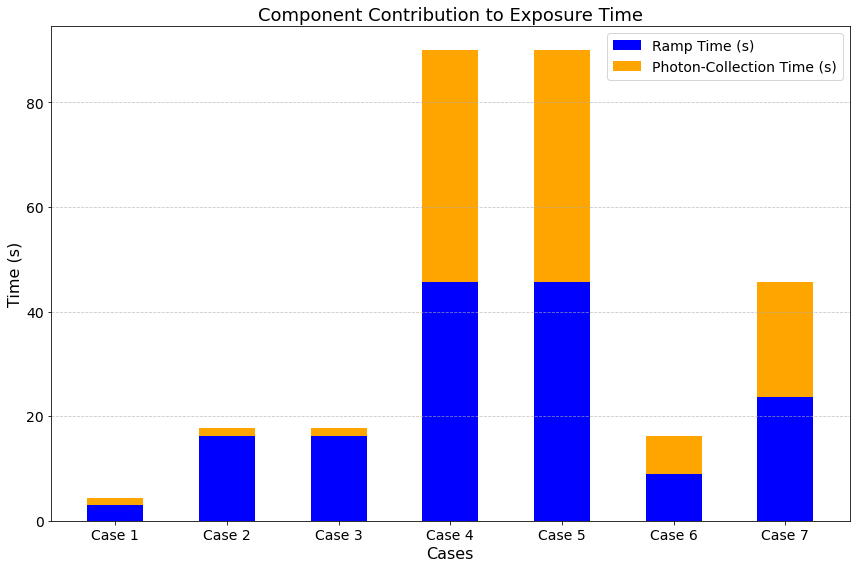

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected Data extracted from the table
cases = [1, 2, 3, 4, 5, 6, 7]
ramps = [1, 1, 5, 1, 5, 5, 5]
coadds = [1, 1, 1, 1, 5, 10, 5]
frame_time = 1475.28  # in ms (constant across all cases)
ramp_time = [2950.56, 16228.08, 16228.08, 45733.68, 45733.68, 8851.68, 23604.48]  # in ms
photon_time = [1475.28, 1475.28, 1475.28, 44258.40, 44258.40, 7376.40, 22129.20]  # in ms
exp_time = [2.95, 16.228, 81.14, 45.73, 1143.34, 442.58, 590.12]  # in seconds

# Convert ramp_time and photon_time to seconds for plotting
ramp_time_seconds = np.array(ramp_time) / 1000
photon_time_seconds = np.array(photon_time) / 1000

# Plot Component Contribution to Exposure Time
plt.figure(figsize=(12, 8))
width = 0.5  # Width of the bars
indices = np.arange(len(cases))

# Plot ramp time and photon time as stacked bars
plt.bar(indices, ramp_time_seconds, width=width, label="Ramp Time (s)", color="blue")
plt.bar(indices, photon_time_seconds, width=width, label="Photon-Collection Time (s)", 
        bottom=ramp_time_seconds, color="orange")

# Customize ticks, labels, and title
plt.xticks(indices, [f"Case {c}" for c in cases], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Cases", fontsize=16)
plt.ylabel("Time (s)", fontsize=16)
plt.title("Component Contribution to Exposure Time", fontsize=18)

# Add legend and grid
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
# plt.savefig("component_contribution_exposure_time.png", dpi=300)
plt.show()


# spatial and temporal

In [ ]:
# Define parameters
# Define a range of threshold factors to test
threshold_factors = [50]
neighborhood_size = 80  # Adjust this size
window_size = 10  # Adjust this size

# Process each image in the folder
fits_filenames = ["ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits",
                  "ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits"]

for factor in threshold_factors:
    print(f"Testing with threshold factor: {factor}")
    for fits_filename in fits_filenames:
        process_image(fits_filename, factor, neighborhood_size, window_size)